# High-Resolution Prediction of MRT, Air Temperature, and Wind Speed  
### Using Random Forest and Gradient Boosting

---

## Summary

Training of a model that predicts 1000×1000 pixel fields of:

- Mean Radiant Temperature (MRT) [K]  
- Air Temperature (AT) [K]  
- Velocity Magnitude (MagVel) [m/s]

based on 5 input features:
- Hour [h]  
- Windspeed [m/s]  
- Wind Direction [°]  
- Solar Irradiance [W/m²]  
- Air Temperature [K]

## Steps
- Load Data
    - Split into training and testing datasets
    - Rebalance training input features
- PCA Compression  
  - Targets compressed to retain 99.99% explained variance (with a component cap if needed).

- Modeling
  - Random Forest: MagVel, AT  
  - Gradient Boosting: MRT  
  - Hyperparameter optimization via GridSearchCV.

- Evaluation
  - Metrics: R², MAE, RMSE  
  - Separate Daytime/Nighttime metric analysis  
  - Feature importances visualized.

- Visualizations
  - True vs Predicted sample images  
  - MAE vs Input Features  
  - Distributions of features before and after balancing.

- Final Outputs
  - Trained models and PCA transformers saved.


In [2]:
import os
import random
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from statsmodels.nonparametric.smoothers_lowess import lowess

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# ==============================
# Configuration
# ==============================

CSV_DIR = "../data/X"  # Directory containing CSV files with input features
IMG_DIR = "../data/Y"  # Directory containing image files for targets (MRT, AT, MagVel)
BUILDING_MASK_PATH = "../RawSimOutputData/6Bldgs/BldgMask150cm-BlackWhiteWithAntiAlias.png"  # Path to the building mask image
DILATION_PIXELS = 2  # Number of pixels to dilate the building mask (optional smoothing/expansion)

# ==============================
# Helper Functions
# ==============================

def parse_image_metadata(filename):
    """
    Extracts metadata from the filename using regex.
    Expected format: YYYY-MM-DD_6Bldgs_TYPE_RANGE_HOUR.png
    Example: 2024-10-03_6Bldgs_MRT_280-320K_14.png
    Returns a dictionary with date, type (MRT/AT/MagVel), value range, and hour.
    """
    pattern = r"(?P<date>\d{4}-\d{2}-\d{2})_6Bldgs_(?P<type>AT|MRT|MagVel)_(?P<range>[0-9\-]+(?:K|ms))_(?P<hour>\d+)\.png"
    match = re.match(pattern, os.path.basename(filename))
    if not match:
        raise ValueError(f"Filename not in expected format: {filename}")
    
    value_range = match.group("range")
    nums = re.findall(r"\d+", value_range)

    return {
        "date": match.group("date"),
        "type": match.group("type"),
        "range": value_range,
        "hour": int(match.group("hour")),
        "value_min": float(nums[0]),
        "value_max": float(nums[1])
    }

def load_clean_building_mask(mask_path, dilation=2):
    """
    Loads a grayscale building mask from the given path.
    Applies dilation to expand the mask if specified.
    Returns a binary mask where buildings are marked as True (masked).
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Could not load building mask: {mask_path}")
    
    # Convert to binary: 0 (black) = building, 255 (white) = non-building
    binary_mask = (mask == 0).astype(np.uint8)

    # Optional dilation to expand building areas slightly
    if dilation > 0:
        kernel = np.ones((3, 3), np.uint8)
        binary_mask = cv2.dilate(binary_mask, kernel, iterations=dilation)

    return binary_mask.astype(bool)

def load_image_with_building_mask(image_path, return_metadata=False, mask_path=BUILDING_MASK_PATH, dilation=DILATION_PIXELS):
    """
    Loads an image, rescales pixel values based on metadata, and applies a building mask.
    - Converts color image to grayscale and rescales pixel values using min/max from filename.
    - Applies the building mask (sets masked pixels to NaN).
    - Optionally returns image metadata.

    Args:
        image_path: Path to the image file.
        return_metadata: If True, also returns parsed metadata.
        mask_path: Path to the building mask file.
        dilation: Number of pixels for mask dilation.

    Returns:
        Scaled image with buildings masked out, optionally with metadata.
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Load image and convert to grayscale
    img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise ValueError(f"cv2 failed to load image: {image_path}")
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)

    # Parse metadata and rescale pixel values to physical range
    meta = parse_image_metadata(image_path)
    img_scaled = meta["value_min"] + (img_gray / 255.0) * (meta["value_max"] - meta["value_min"])

    # Load building mask and apply
    bldg_mask = load_clean_building_mask(mask_path, dilation=dilation)
    if bldg_mask.shape != img_scaled.shape:
        raise ValueError("Mask and image dimensions do not match")

    img_scaled[bldg_mask] = np.nan  # Mask out building areas

    return (img_scaled, meta) if return_metadata else img_scaled

# Load Sample Training Data

Random sample selected: 5values_2024-04-12_24.csv

5 Input Values:
Hour                        24.000000
Windspeed (m/s)              0.694444
Wind Direction (deg)        69.000000
Solar Irradiance (W/m2)      0.000000
Air Temperature (K)        290.050000


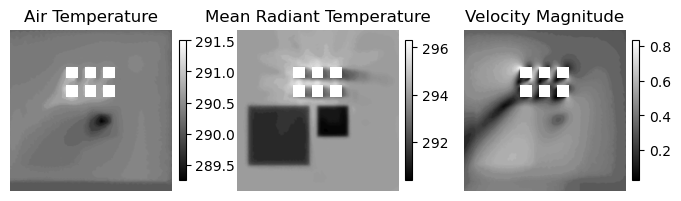

In [4]:
# ==============================
# Load and Visualize Random Sample
# ==============================

# --- Select Random CSV Sample ---
csv_files = [f for f in os.listdir(CSV_DIR) if f.startswith("5values_") and f.endswith(".csv")]
chosen_csv = random.choice(csv_files)
csv_path = os.path.join(CSV_DIR, chosen_csv)

# Extract date and hour from filename (format: 5values_YYYY-MM-DD_HH.csv)
parts = chosen_csv.split("_")
date_str = parts[1]  # e.g., '2024-10-03'
hour = int(parts[2].split(".")[0])  # e.g., '14'
print(f"Random sample selected: {chosen_csv}")

# --- Load 5 Input Features ---
df = pd.read_csv(csv_path)
print("\n5 Input Values:")
print(df.iloc[0].to_string(index=True))

# ==============================
# Load Corresponding Target Images
# ==============================

image_tags = {
    "AT": "Air Temperature",
    "MRT": "Mean Radiant Temperature",
    "MagVel": "Velocity Magnitude"
}

images = {}  # Store loaded images
metas = {}   # Store associated metadata

# --- Find and Load Images ---
for tag, label in image_tags.items():
    # Find image matching date, type, and hour
    matches = [f for f in os.listdir(IMG_DIR) if f.startswith(date_str) and tag in f and f.endswith(f"_{hour}.png")]
    if matches:
        image_path = os.path.join(IMG_DIR, matches[0])
        img, meta = load_image_with_building_mask(image_path, return_metadata=True)
        images[label] = img
        metas[label] = meta
    else:
        print(f"No image found for {label} at {date_str}, hour {hour}")

# ==============================
# Visualize Images for Paper (Fixed Width)
# ==============================

if not images:
    print(f"No images found for any tag at {date_str}, hour {hour}")
else:
    num_images = len(images)
    fig_width = 7  # Fixed width for A4
    fig_height = 5  # Moderate height to keep proportions good for paper

    fig, axs = plt.subplots(1, num_images, figsize=(fig_width, fig_height))

    if num_images == 1:
        axs = [axs]  # Make iterable

    for i, (label, img) in enumerate(images.items()):
        im = axs[i].imshow(img, cmap="gray")
        cbar = plt.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.04, pad=0.04)
        axs[i].set_title(f"{label}", fontsize=12)
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

# Analyze available Training Data 

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === CONFIGURATION ===
CSV_DIR = "../data/X"         # Directory containing CSV files with 5 input values
IMG_DIR = "../data/Y"         # Directory containing target images
TARGET_TYPES = ["MRT", "MagVel", "AT"]  # Target variables to process

# === DATA STORAGE ===
X_features = []                          # Input features (Hour, Windspeed, etc.)
Y_images = {tt: [] for tt in TARGET_TYPES}  # Target images (flattened)

# === LOAD FEATURES AND IMAGES ===
for csv_file in sorted(os.listdir(CSV_DIR)):
    if not csv_file.startswith("5values_") or not csv_file.endswith(".csv"):
        continue  # Skip irrelevant files

    # Extract date and hour from filename
    date = csv_file.split("_")[1]
    hour = int(csv_file.split("_")[2].split(".")[0])
    csv_path = os.path.join(CSV_DIR, csv_file)

    # Load the 5 input features from CSV
    df = pd.read_csv(csv_path)
    features = df.iloc[0][["Hour", "Windspeed (m/s)", "Wind Direction (deg)", "Solar Irradiance (W/m2)", "Air Temperature (K)"]].values

    # Check if all required target images exist for this sample
    image_paths = {}
    for target in TARGET_TYPES:
        pattern = f"{date}_6Bldgs_{target}_"
        matches = [f for f in os.listdir(IMG_DIR) if f.startswith(pattern) and f.endswith(f"_{hour}.png")]
        if not matches:
            break  # Skip this sample if any target image is missing
        image_paths[target] = os.path.join(IMG_DIR, matches[0])
    else:
        # If all target images exist, load them and append data
        try:
            X_features.append(features)  # Append input features
            for target in TARGET_TYPES:
                img, meta = load_image_with_building_mask(image_paths[target], return_metadata=True)
                if np.isnan(img).all():
                    raise ValueError("Image contains only NaNs")
                flat_img = img.flatten()
                flat_img[np.isnan(flat_img)] = 0  # Replace NaNs with 0 for PCA
                Y_images[target].append(flat_img)
        except Exception as e:
            print(f"Error processing {date} {hour}: {e}")
            continue  # Skip to next sample if any error occurs

# === FINAL CONVERSION TO ARRAYS ===
X_features = np.array(X_features)
for target in TARGET_TYPES:
    Y_images[target] = np.array(Y_images[target])

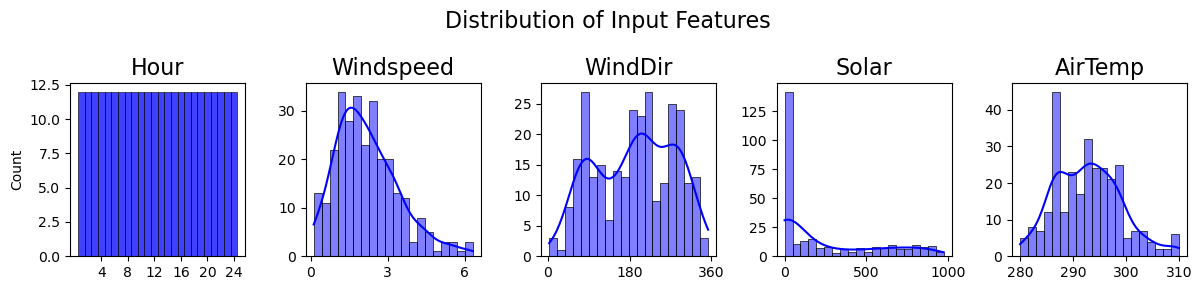

In [6]:
# === CONVERT INPUT FEATURES TO DATAFRAME ===
df_features = pd.DataFrame(X_features, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

# === PLOT DISTRIBUTIONS OF EACH FEATURE ===
features = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]
fig, axs = plt.subplots(1, 5, figsize=(12, 3))  # Optimized for paper width
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for idx, feat in enumerate(features):
    if feat == "Hour":
        sns.histplot(df_features[feat], bins=np.arange(1, 26), ax=axs[idx], kde=False, color="blue", edgecolor='black', discrete=True)
        axs[idx].set_xticks(np.arange(4, 25, 4))
    else:
        sns.histplot(df_features[feat], bins=20, kde=True, ax=axs[idx], color='blue', edgecolor='black')

    # --- Adjust x-axis ticks ---
    if feat == "Windspeed":
        axs[idx].set_xticks([0, 3, 6])
    elif feat == "WindDir":
        axs[idx].set_xticks([0, 180, 360])
    elif feat == "AirTemp":
        axs[idx].set_xticks([280, 290, 300, 310])

    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("Count")
    axs[idx].set_title(f"{feat}",fontsize=16)
    if idx != 0:
        axs[idx].set_ylabel("")
# === OVERALL PLOT ADJUSTMENTS ===
plt.suptitle("Distribution of Input Features", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

Text(0.5, 1.0, 'Correlation Matrix of Input Features')

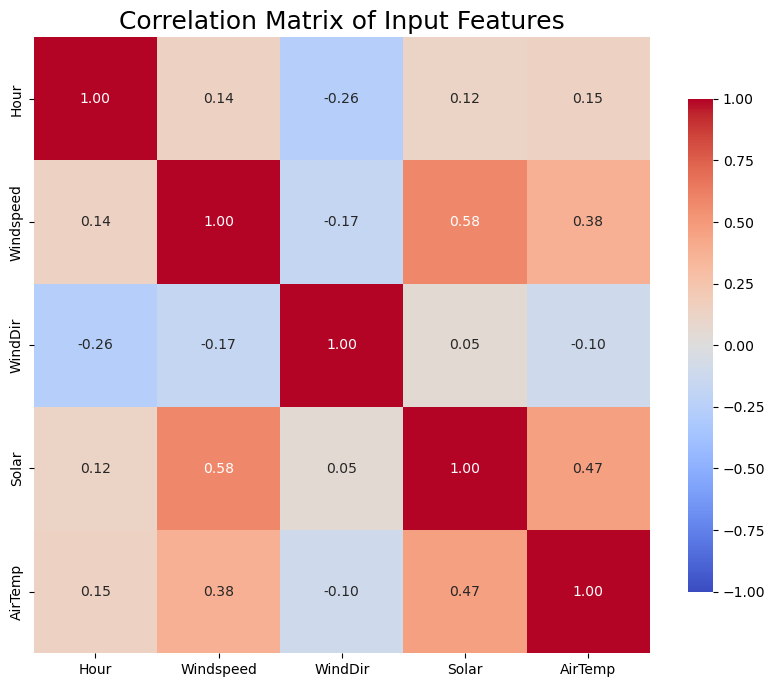

In [7]:
# plot correalation of X
corr = df_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1 , square=True, cbar_kws={"shrink": .8})

plt.title("Correlation Matrix of Input Features", fontsize=18)



# Check distribution of Training data And Rebalance by duplicating

--> problem: theres  a skew towards certain conditions in the 5 values used for training. 
Some combinations especially for windspeed and solar radiation are overrepresented. 

In [8]:
#==============================
# Train-Test Split and Prepare for Balancing
# ==============================

# --- Convert full feature array to DataFrame ---
df_features_all = pd.DataFrame(X_features, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

# --- Perform train-test split (15% for testing) ---
X_train_orig, X_test, train_indices, test_indices = train_test_split(
    X_features, range(len(X_features)), test_size=0.15, random_state=42, shuffle=True
)
df_features_train_before = pd.DataFrame(X_train_orig, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

# ==============================
# Data Balancing by Binning and Upsampling
# ==============================

# --- Bin training data by Windspeed, Solar, and Wind Direction ---
combined_data = df_features_train_before.copy()
combined_data["target_index"] = list(range(len(combined_data)))
combined_data["wind_bin"] = pd.cut(combined_data["Windspeed"], bins=5)
combined_data["solar_bin"] = pd.cut(combined_data["Solar"], bins=5)
combined_data["winddir_bin"] = pd.cut(combined_data["WindDir"], bins=5)

# --- Determine bin counts and threshold for balancing ---
grouped = combined_data.groupby(["wind_bin", "solar_bin", "winddir_bin"]).size().reset_index(name='count')
valid_bins = grouped[grouped['count'] > 0]
percentile_threshold = int(np.ceil(valid_bins['count'].quantile(0.8)))

print(f"80th percentile threshold (rounded up): {percentile_threshold}")

print("\n--- Bin Statistics Before Balancing ---")
print(f"Total number of bins: {len(grouped)}")
print(f"Number of non-empty bins: {len(valid_bins)}")
print(f"Bin counts (min/median/max): {valid_bins['count'].min()} / {valid_bins['count'].median()} / {valid_bins['count'].max()}")
print(f"80th percentile threshold for upsampling: {percentile_threshold}\n")

# --- Balance dataset: Upsample bins below threshold ---
balanced_indices = []

for _, row in valid_bins.iterrows():
    mask = (combined_data["wind_bin"] == row["wind_bin"]) & \
           (combined_data["solar_bin"] == row["solar_bin"]) & \
           (combined_data["winddir_bin"] == row["winddir_bin"])

    subset = combined_data[mask]

    if row["count"] < percentile_threshold:
        upsampled = resample(subset, replace=True, n_samples=int(percentile_threshold), random_state=42)
        balanced_indices.extend(upsampled["target_index"].tolist())
    else:
        balanced_indices.extend(subset["target_index"].tolist())

# --- Create balanced training data from selected indices ---
X_train_balanced = X_train_orig[balanced_indices]
df_features_train_after = pd.DataFrame(X_train_balanced, columns=["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"])

print(f"Balanced training dataset created: {len(X_train_balanced)} samples (original training: {len(X_train_orig)})")

80th percentile threshold (rounded up): 7

--- Bin Statistics Before Balancing ---
Total number of bins: 125
Number of non-empty bins: 54
Bin counts (min/median/max): 1 / 2.0 / 24
80th percentile threshold for upsampling: 7

Balanced training dataset created: 449 samples (original training: 244)


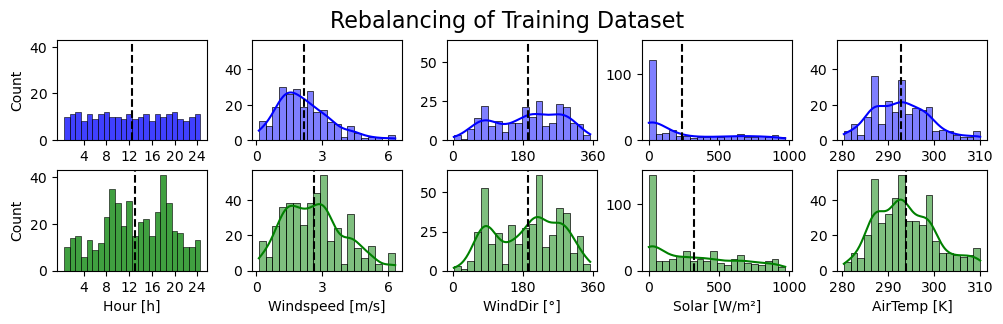

In [9]:
# ==============================
# Visualize Distributions Before and After Balancing
# ==============================

# --- Define features and units ---
features = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]
feature_units = {
    "Hour": "Hour [h]",
    "Windspeed": "Windspeed [m/s]",
    "WindDir": "WindDir [°]",
    "Solar": "Solar [W/m²]",
    "AirTemp": "AirTemp [K]"
}

# --- Create subplot grid (2 rows: before / after balancing) ---
fig, axs = plt.subplots(2, 5, figsize=(12, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for idx, feat in enumerate(features):
    # --- Plot distribution before balancing ---
    if feat == "Hour":
        hist_b = sns.histplot(df_features_train_before[feat], bins=np.arange(1, 26), ax=axs[0, idx], kde=False, color="blue", discrete=True)
    else:
        hist_b = sns.histplot(df_features_train_before[feat], bins=20, ax=axs[0, idx], kde=True, color="blue")

    mean_b = df_features_train_before[feat].mean()
    axs[0, idx].axvline(mean_b, color="black", linestyle="--", linewidth=1.5)

    # --- Plot distribution after balancing ---
    if feat == "Hour":
        hist_a = sns.histplot(df_features_train_after[feat], bins=np.arange(1, 26), ax=axs[1, idx], kde=False, color="green", discrete=True)
    else:
        hist_a = sns.histplot(df_features_train_after[feat], bins=20, ax=axs[1, idx], kde=True, color="green")

    mean_a = df_features_train_after[feat].mean()
    axs[1, idx].axvline(mean_a, color="black", linestyle="--", linewidth=1.5)

    # --- Share y-axis limits between before/after ---
    shared_ymax = max(hist_b.get_ylim()[1], hist_a.get_ylim()[1])
    axs[0, idx].set_ylim(0, shared_ymax)
    axs[1, idx].set_ylim(0, shared_ymax)

    # --- Custom x-axis ticks for clarity ---
    if feat == "Hour":
        axs[0, idx].set_xticks(np.arange(4, 25, 4))
        axs[1, idx].set_xticks(np.arange(4, 25, 4))
    elif feat == "Windspeed":
        axs[0, idx].set_xticks([0, 3, 6])
        axs[1, idx].set_xticks([0, 3, 6])
    elif feat == "WindDir":
        axs[0, idx].set_xticks([0, 180, 360])
        axs[1, idx].set_xticks([0, 180, 360])
    elif feat == "AirTemp":
        axs[0, idx].set_xticks([280, 290, 300, 310])
        axs[1, idx].set_xticks([280, 290, 300, 310])

    # --- Add x-axis labels only to balanced (bottom) row ---
    axs[1, idx].set_xlabel(feature_units[feat])
    axs[0, idx].set_xlabel("")

    # --- Remove y-axis labels except for the first column ---
    if idx != 0:
        axs[0, idx].set_ylabel("")
        axs[1, idx].set_ylabel("")

# --- Keep y-axis label for first column only ---
axs[0, 0].set_ylabel("Count")
axs[1, 0].set_ylabel("Count")

plt.suptitle("Rebalancing of Training Dataset", fontsize=16)
plt.show()

# PCA Compression of Y Images

In [10]:
# ==============================
# PCA for Dimensionality Reduction
# ==============================

# --- Config ---
EXPLAINED_VARIANCE_THRESHOLD = 0.9999  # Target cumulative explained variance (99.99%)
MAX_COMPONENTS = 25  # Cap maximum number of PCA components

# --- Prepare Balanced and Unbalanced Image Sets ---
balanced_indices_global = [train_indices[i] for i in balanced_indices]
Y_images_bal = {tt: Y_images[tt][balanced_indices_global] for tt in TARGET_TYPES}
Y_images_unbal = {tt: Y_images[tt][train_indices] for tt in TARGET_TYPES}

# --- Storage for PCA Models and Transformed Data ---
Y_pca_data_bal = {}
Y_pca_data_unbal = {}
PCA_models_bal = {}
PCA_models_unbal = {}
PCA_full_models_bal = {}
PCA_full_models_unbal = {}
n_components_dict_bal = {}
n_components_dict_unbal = {}

# --- Fit PCA for Each Target ---
for target in TARGET_TYPES:
    # --- PCA for Balanced Data ---
    pca_bal_full = PCA(n_components=EXPLAINED_VARIANCE_THRESHOLD, svd_solver='auto')
    Y_pca_data_bal_full = pca_bal_full.fit_transform(Y_images_bal[target])
    n_used_bal = min(pca_bal_full.n_components_, MAX_COMPONENTS)

    # Fit capped PCA using randomized solver for efficiency
    pca_bal_capped = PCA(n_components=n_used_bal, svd_solver='randomized')
    Y_pca_data_bal[target] = pca_bal_capped.fit_transform(Y_images_bal[target])

    # Store models and component info
    PCA_models_bal[target] = pca_bal_capped
    PCA_full_models_bal[target] = pca_bal_full
    n_components_dict_bal[target] = n_used_bal

    # Check explained variance after capping
    explained_var_bal = np.sum(pca_bal_full.explained_variance_ratio_[:n_used_bal])
    if explained_var_bal < EXPLAINED_VARIANCE_THRESHOLD:
        print(f"Balanced PCA for {target}: {explained_var_bal:.5f} explained with {n_used_bal} components.")

    # --- PCA for Unbalanced Data ---
    pca_unbal_full = PCA(n_components=EXPLAINED_VARIANCE_THRESHOLD, svd_solver='auto')
    Y_pca_data_unbal_full = pca_unbal_full.fit_transform(Y_images_unbal[target])
    n_used_unbal = min(pca_unbal_full.n_components_, MAX_COMPONENTS)

    pca_unbal_capped = PCA(n_components=n_used_unbal, svd_solver='randomized')
    Y_pca_data_unbal[target] = pca_unbal_capped.fit_transform(Y_images_unbal[target])

    PCA_models_unbal[target] = pca_unbal_capped
    PCA_full_models_unbal[target] = pca_unbal_full
    n_components_dict_unbal[target] = n_used_unbal

    explained_var_unbal = np.sum(pca_unbal_full.explained_variance_ratio_[:n_used_unbal])
    if explained_var_unbal < EXPLAINED_VARIANCE_THRESHOLD:
        print(f"Unbalanced PCA for {target}: {explained_var_unbal:.5f} explained with {n_used_unbal} components.")

    # --- Summary Output ---
    print(f"\nPCA complete for {target}")
    print(f"Balanced Image shape: {Y_images_bal[target].shape}")
    print(f"PCA shape (Balanced): {Y_pca_data_bal[target].shape} | Components used: {n_used_bal}")
    print(f"Unbalanced Image shape: {Y_images_unbal[target].shape}")
    print(f"PCA shape (Unbalanced): {Y_pca_data_unbal[target].shape} | Components used: {n_used_unbal}")

# ==============================
# PCA Transformation of Test Data
# ==============================

Y_pca_data_test_bal = {}
Y_pca_data_test_unbal = {}

for target in TARGET_TYPES:
    Y_test_images = Y_images[target][test_indices]

    # Apply capped PCA models to test data
    Y_pca_data_test_bal[target] = PCA_models_bal[target].transform(Y_test_images)
    Y_pca_data_test_unbal[target] = PCA_models_unbal[target].transform(Y_test_images)

    print(f"\nTest set PCA-transformed for {target}:")
    print(f" - Shape (Balanced PCA):   {Y_pca_data_test_bal[target].shape}")
    print(f" - Shape (Unbalanced PCA): {Y_pca_data_test_unbal[target].shape}")


PCA complete for MRT
Balanced Image shape: (449, 1000000)
PCA shape (Balanced): (449, 19) | Components used: 19
Unbalanced Image shape: (244, 1000000)
PCA shape (Unbalanced): (244, 19) | Components used: 19
Balanced PCA for MagVel: 0.99873 explained with 25 components.
Unbalanced PCA for MagVel: 0.99790 explained with 25 components.

PCA complete for MagVel
Balanced Image shape: (449, 1000000)
PCA shape (Balanced): (449, 25) | Components used: 25
Unbalanced Image shape: (244, 1000000)
PCA shape (Unbalanced): (244, 25) | Components used: 25

PCA complete for AT
Balanced Image shape: (449, 1000000)
PCA shape (Balanced): (449, 7) | Components used: 7
Unbalanced Image shape: (244, 1000000)
PCA shape (Unbalanced): (244, 8) | Components used: 8

Test set PCA-transformed for MRT:
 - Shape (Balanced PCA):   (44, 19)
 - Shape (Unbalanced PCA): (44, 19)

Test set PCA-transformed for MagVel:
 - Shape (Balanced PCA):   (44, 25)
 - Shape (Unbalanced PCA): (44, 25)

Test set PCA-transformed for AT:

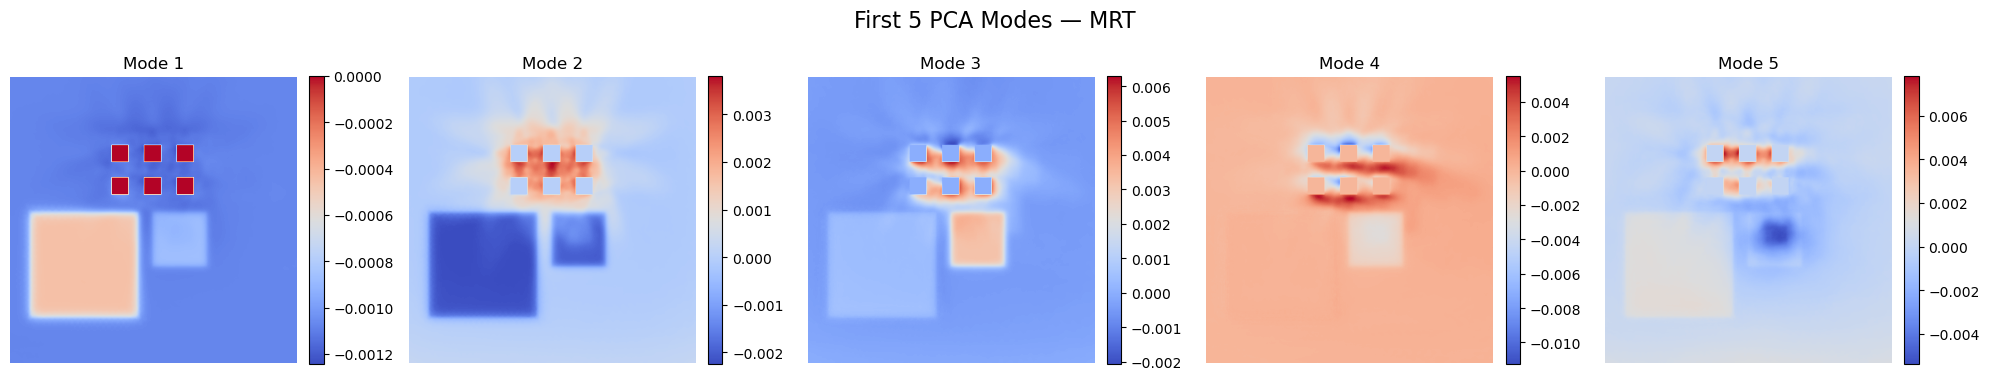

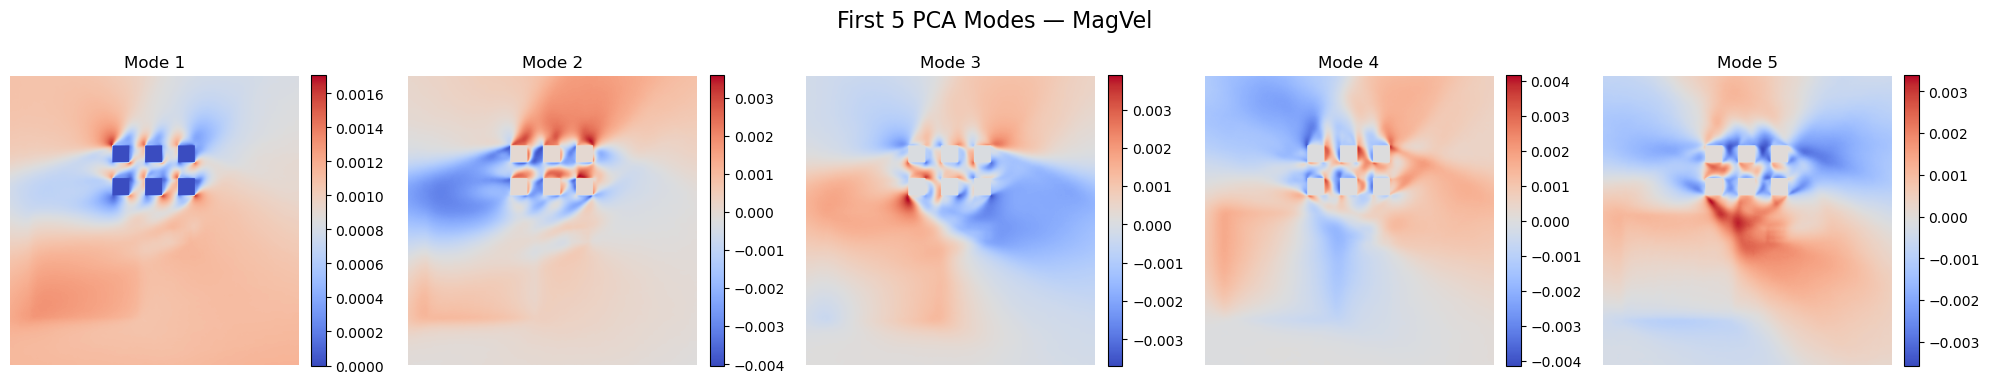

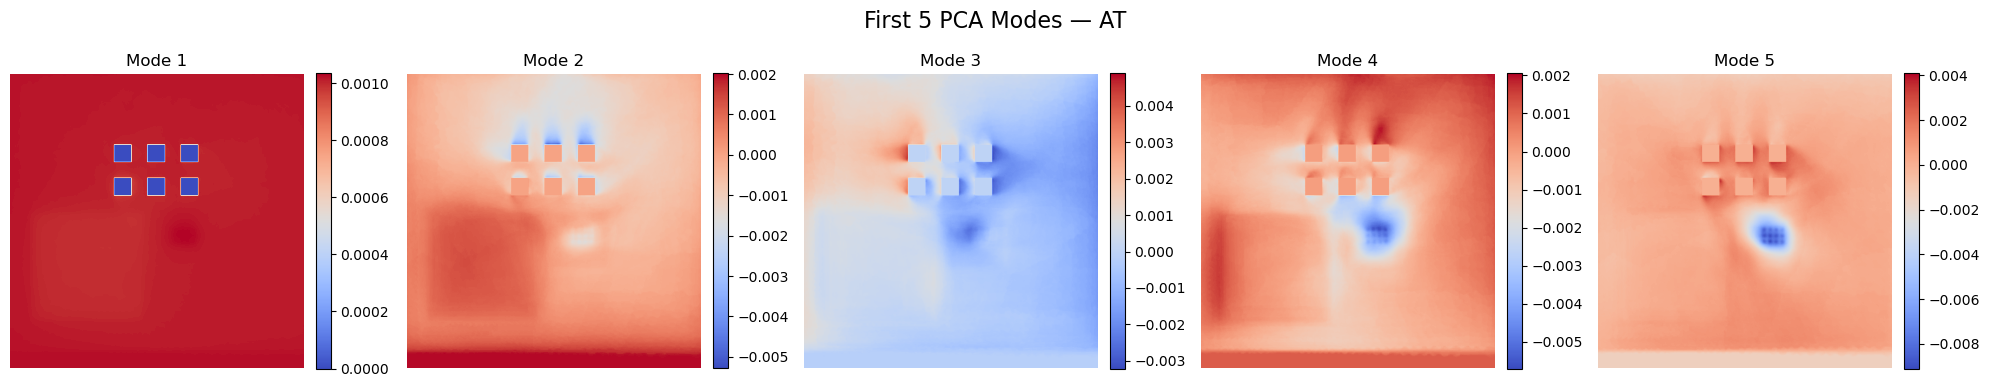

In [ ]:

# --- Original Image shape ---
img_height, img_width = 1000, 1000  
n_modes_to_show = 5 #PCA modes to show

# --- Visualize first 3 PCA modes for each target ---
for target in TARGET_TYPES:
    pca_model = PCA_models_bal[target]  # Use the balanced PCA model
    components = pca_model.components_[:n_modes_to_show]

    fig, axs = plt.subplots(1, n_modes_to_show, figsize=(4 * n_modes_to_show, 4))
    fig.suptitle(f"First {n_modes_to_show} PCA Modes — {target}", fontsize=16)

    for i in range(n_modes_to_show):
        mode = components[i].reshape((img_height, img_width))
        ax = axs[i]
        im = ax.imshow(mode, cmap='coolwarm')
        ax.set_title(f"Mode {i+1}")
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

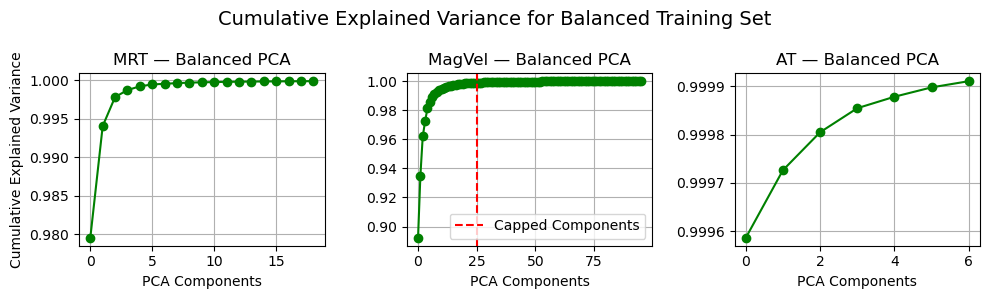

In [19]:
# ==============================
# Plot Cumulative Explained Variance (Balanced Dataset Only)
# ==============================

fig, axs = plt.subplots(1, 3, figsize=(10, 3))  # 1 row × 3 targets

for idx, target in enumerate(TARGET_TYPES):
    pca_bal_full = PCA_full_models_bal[target]
    n_used_bal = n_components_dict_bal[target]

    # Plot cumulative explained variance
    axs[idx].plot(np.cumsum(pca_bal_full.explained_variance_ratio_), marker="o", color="green")

    # Show cap line only if components were capped
    if pca_bal_full.n_components_ > MAX_COMPONENTS:
        axs[idx].axvline(n_used_bal, color="red", linestyle="--", label="Capped Components")
        axs[idx].legend()

    axs[idx].set_title(f"{target} — Balanced PCA", fontsize=12)
    axs[idx].set_xlabel("PCA Components")
    axs[idx].set_ylabel("Cumulative Explained Variance")
    axs[idx].grid(True)
    if idx >= 1:
        axs[idx].set_ylabel("")
# --- Overall Figure Adjustments ---
plt.suptitle("Cumulative Explained Variance for Balanced Training Set", fontsize=14)
plt.tight_layout()
plt.show()

# Crossvalidation to find optimal Hyperparams for RFs 

In [11]:
# ==============================
# Random Forest Training with Grid Search
# ==============================

# --- Storage for models and results ---
rf_models = {}
rf_results = {}

# --- Hyperparameter grid for tuning ---
param_grid = {
    "estimator__n_estimators": [200, 250, 300],
    "estimator__max_depth": [10, 20, 30],
    "estimator__min_samples_split": [2, 3, 4],
}

# --- Toggle for balanced or unbalanced data ---
use_balanced = True  # Set to False for unbalanced training

# --- Select dataset accordingly ---
X_train_full = X_train_balanced if use_balanced else X_train_orig
PCA_models_current = PCA_models_bal if use_balanced else PCA_models_unbal
Y_pca_data_current = Y_pca_data_bal if use_balanced else Y_pca_data_unbal
Y_pca_data_test_current = Y_pca_data_test_bal if use_balanced else Y_pca_data_test_unbal

print(f"\nUsing {'BALANCED' if use_balanced else 'UNBALANCED'} training dataset.")

# --- Loop through all target variables ---
for target in ["MRT", "MagVel", "AT"]:
    print(f"\nTraining Random Forest with GridSearchCV for {target}...")

    y_target_train = Y_pca_data_current[target]
    y_target_test = Y_pca_data_test_current[target]
    pca_model = PCA_models_current[target]

    X_target_train = X_train_full.copy()
    feature_names = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]

    # Inject noise for AT if using balanced data 
    if target == "AT" and use_balanced:
        X_target_train[:, -1] += np.random.normal(0, 0.5, size=X_target_train.shape[0]) #Adds noise of +- 0.5
        print('AT target noise injected')

    print(f"Training on {len(X_target_train)} samples | Evaluating on {len(X_test)} test samples")

    # --- Define and fit model with GridSearchCV ---
    base_rf = RandomForestRegressor(n_jobs=1, random_state=42)
    multi_rf = MultiOutputRegressor(base_rf, n_jobs=1)

    grid = GridSearchCV(
        multi_rf,
        param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        verbose=2,
        n_jobs=50
    )

    grid.fit(X_target_train, y_target_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # --- Inverse PCA reconstruction ---
    y_true_recon = pca_model.inverse_transform(y_target_test)
    y_pred_recon = pca_model.inverse_transform(y_pred)

    nan_mask = y_true_recon == 0
    y_true_recon[nan_mask] = np.nan
    y_pred_recon[nan_mask] = np.nan

    valid = ~np.isnan(y_true_recon)
    flat_true = y_true_recon[valid]
    flat_pred = y_pred_recon[valid]

    # --- Compute evaluation metrics ---
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

    # --- Store model and results ---
    rf_models[target] = best_model
    rf_results[target] = {
        "X_test": X_test,
        "y_test": y_target_test,
        "y_pred": y_pred,
        "flat_true": flat_true,
        "flat_pred": flat_pred,
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "best_params": grid.best_params_,
        "feature_names": feature_names
    }

    print(f"Best params for {target}: {grid.best_params_}")
    print(f"Metrics in physical units:")
    print(f"   R² Score:  {r2:.3f}")
    print(f"   MAE:       {mae:.3f}")
    print(f"   RMSE:      {rmse:.3f}")

# ==============================
# Feature Importance Display
# ==============================

for target in ["MRT", "MagVel", "AT"]:
    importances = rf_models[target].estimators_[0].feature_importances_
    feature_names = rf_results[target]['feature_names']
    print(f"\nFeature importances for {target}:")
    for feat, imp in zip(feature_names, importances):
        print(f"{feat}: {imp:.3f}")


Using BALANCED training dataset.

Training Random Forest with GridSearchCV for MRT...
Training on 449 samples | Evaluating on 44 test samples
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for MRT: {'estimator__max_depth': 20, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Metrics in physical units:
   R² Score:  0.867
   MAE:       1.281
   RMSE:      1.993

Training Random Forest with GridSearchCV for MagVel...
Training on 449 samples | Evaluating on 44 test samples
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for MagVel: {'estimator__max_depth': 30, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 300}
Metrics in physical units:
   R² Score:  0.961
   MAE:       0.137
   RMSE:      0.223

Training Random Forest with GridSearchCV for AT...
AT target noise injected
Training on 449 samples | Evaluating on 44 test samples
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for

# Gradboosting Model for lowest performing Variable: MRT

In [12]:
# ==============================
# Gradient Boosting for MRT with Grid Search
# ==============================

# --- Prepare training and test data for MRT ---
X_mrt_train = X_train_full.copy()
y_mrt_train = Y_pca_data_current["MRT"]
y_mrt_test = Y_pca_data_test_current["MRT"]
pca_model = PCA_models_current["MRT"]

print("\nGridSearchCV for Gradient Boosting MRT...")

# --- Define hyperparameter grid ---
gb_param_grid = {
    "estimator__n_estimators": [170, 200, 230],
    "estimator__max_depth": [3, 5, 7],
    "estimator__learning_rate": [0.05, 0.1]
}

# --- Define base model and wrapper for multi-output regression ---
gb_base = GradientBoostingRegressor(random_state=42)
gb_multi = MultiOutputRegressor(gb_base, n_jobs=1)

# --- Grid Search with 5-fold CV ---
gb_grid = GridSearchCV(
    gb_multi,
    gb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2,
    n_jobs=20
)

# --- Fit model ---
gb_grid.fit(X_mrt_train, y_mrt_train)
best_gb_model = gb_grid.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)

# --- Inverse PCA reconstruction ---
y_true_recon = pca_model.inverse_transform(y_mrt_test)
y_pred_recon = pca_model.inverse_transform(y_pred_gb)

nan_mask = y_true_recon == 0
y_true_recon[nan_mask] = np.nan
y_pred_recon[nan_mask] = np.nan

valid = ~np.isnan(y_true_recon)
flat_true = y_true_recon[valid]
flat_pred = y_pred_recon[valid]

# --- Compute evaluation metrics ---
r2 = r2_score(flat_true, flat_pred)
mae = mean_absolute_error(flat_true, flat_pred)
rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

# --- Display results ---
print("Boosted MRT GridSearchCV complete")
print(f" R² Score:  {r2:.3f}")
print(f" MAE:       {mae:.3f}")
print(f" RMSE:      {rmse:.3f}")
print(f"\nBest Gradient Boosting Params: {gb_grid.best_params_}")

# --- Feature importances ---
importances = best_gb_model.estimators_[0].feature_importances_
print(f"\nFeature importances for Boosted MRT:")
for feat, imp in zip(feature_names, importances):
    print(f"{feat}: {imp:.3f}")


GridSearchCV for Gradient Boosting MRT...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Boosted MRT GridSearchCV complete
 R² Score:  0.875
 MAE:       1.219
 RMSE:      1.937

Best Gradient Boosting Params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 200}

Feature importances for Boosted MRT:
Hour: 0.096
Windspeed: 0.105
WindDir: 0.028
Solar: 0.063
AirTemp: 0.708


# Final Training:

In [13]:
# ==============================
# Final Model Training Using Best Hyperparameters
# ==============================

# --- Storage for final models and results ---
final_models = {}
final_results = {}

# --- Toggle between balanced and unbalanced datasets ---
use_balanced = True

# --- Select datasets based on toggle ---
X_train_full = X_train_balanced if use_balanced else X_train_orig
PCA_models_current = PCA_models_bal if use_balanced else PCA_models_unbal
Y_pca_data_current = Y_pca_data_bal if use_balanced else Y_pca_data_unbal
Y_pca_data_test_current = Y_pca_data_test_bal if use_balanced else Y_pca_data_test_unbal

print(f"\nUsing {'BALANCED' if use_balanced else 'UNBALANCED'} training dataset.")

# --- Loop through each target variable ---
for target in ["MRT", "MagVel", "AT"]:
    print(f"\nTraining Final Model for {target}...")

    y_train = Y_pca_data_current[target]
    y_test = Y_pca_data_test_current[target]
    pca_model = PCA_models_current[target]
    X_train = X_train_full.copy()

    # Inject noise into AirTemp if using balanced data
    if target == "AT" and use_balanced:
        X_train[:, -1] += np.random.normal(0, 0.5, size=X_train.shape[0])
        print('AT target noise injected')

    # --- Select model type based on target ---
    if target == "MRT":
        # Gradient Boosting for MRT using best parameters
        gb_params_best = gb_grid.best_params_
        print(f"Using Best Gradient Boosting Params for MRT: {gb_params_best}")
        gb_params_clean = {
            "n_estimators": gb_params_best["estimator__n_estimators"],
            "max_depth": gb_params_best["estimator__max_depth"],
            "learning_rate": gb_params_best["estimator__learning_rate"],
            "random_state": 42
        }
        model = MultiOutputRegressor(GradientBoostingRegressor(**gb_params_clean), n_jobs=1)
    else:
        # Random Forest for MagVel and AT using best parameters
        rf_params_best = rf_results[target]["best_params"]
        print(f"Using Best Random Forest Params for {target}: {rf_params_best}")
        rf_params_clean = {
            "n_estimators": rf_params_best["estimator__n_estimators"],
            "max_depth": rf_params_best["estimator__max_depth"],
            "min_samples_split": rf_params_best["estimator__min_samples_split"],
            "n_jobs": 60,
            "random_state": 42
        }
        base_rf = RandomForestRegressor(**rf_params_clean)
        model = MultiOutputRegressor(base_rf, n_jobs=1)

    # --- Train model ---
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- Inverse PCA to reconstruct full images ---
    y_true_recon = pca_model.inverse_transform(y_test)
    y_pred_recon = pca_model.inverse_transform(y_pred)

    nan_mask = y_true_recon == 0
    y_true_recon[nan_mask] = np.nan
    y_pred_recon[nan_mask] = np.nan

    valid = ~np.isnan(y_true_recon)
    flat_true = y_true_recon[valid]
    flat_pred = y_pred_recon[valid]

    # --- Compute performance metrics ---
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))

    # --- Store model and metrics ---
    final_models[target] = model
    final_results[target] = {
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "flat_true": flat_true,
        "flat_pred": flat_pred,
    }

    print(f"Final Model Trained for {target}")
    print(f" R² Score:  {r2:.3f}")
    print(f" MAE:       {mae:.3f}")
    print(f" RMSE:      {rmse:.3f}")

# --- Feature importances ---
for target in ["MRT", "MagVel", "AT"]:
    print(f"\nFeature importances for {target}:")
    importances = final_models[target].estimators_[0].feature_importances_
    for feat, imp in zip(["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"], importances):
        print(f"{feat}: {imp:.3f}")


Using BALANCED training dataset.

Training Final Model for MRT...
Using Best Gradient Boosting Params for MRT: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 200}
Final Model Trained for MRT
 R² Score:  0.875
 MAE:       1.219
 RMSE:      1.937

Training Final Model for MagVel...
Using Best Random Forest Params for MagVel: {'estimator__max_depth': 30, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 300}
Final Model Trained for MagVel
 R² Score:  0.961
 MAE:       0.137
 RMSE:      0.223

Training Final Model for AT...
AT target noise injected
Using Best Random Forest Params for AT: {'estimator__max_depth': 10, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 200}
Final Model Trained for AT
 R² Score:  0.994
 MAE:       0.381
 RMSE:      0.478

Feature importances for MRT:
Hour: 0.096
Windspeed: 0.105
WindDir: 0.028
Solar: 0.063
AirTemp: 0.708

Feature importances for MagVel:
Hour: 0.009
Windspeed: 0.727
WindDir: 0.006

# Evaluate Feature Importance Per Variable


Feature importances for MRT:
Hour: 0.096
Windspeed: 0.105
WindDir: 0.028
Solar: 0.063
AirTemp: 0.708

Feature importances for MagVel:
Hour: 0.009
Windspeed: 0.727
WindDir: 0.006
Solar: 0.007
AirTemp: 0.251

Feature importances for AT:
Hour: 0.001
Windspeed: 0.002
WindDir: 0.002
Solar: 0.002
AirTemp: 0.993


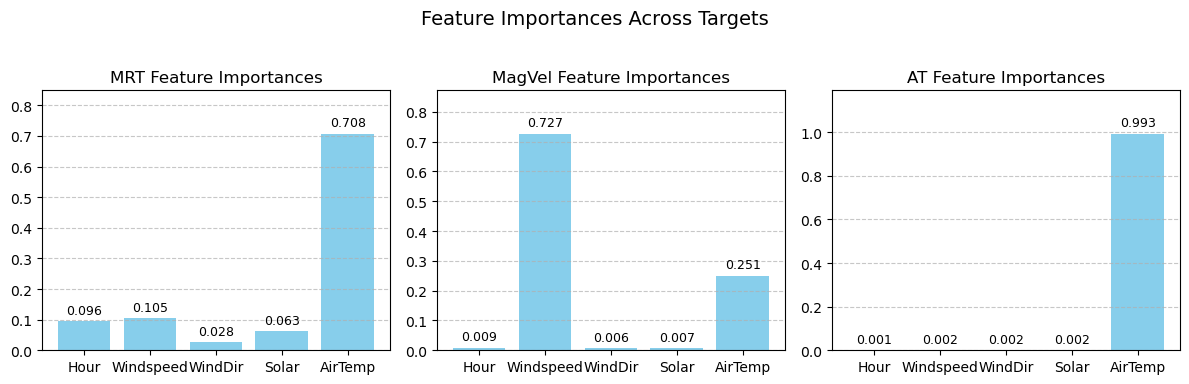

In [14]:
# ==============================
# Plot Feature Importances for Each Target Variable
# ==============================

feature_names = ["Hour", "Windspeed", "WindDir", "Solar", "AirTemp"]
targets = ["MRT", "MagVel", "AT"]

# --- Create subplot with 1 row and 3 columns (A4-friendly width) ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for idx, target in enumerate(targets):
    print(f"\nFeature importances for {target}:")
    
    # --- Retrieve feature importances ---
    importances = final_models[target].estimators_[0].feature_importances_
    for feat, imp in zip(feature_names, importances):
        print(f"{feat}: {imp:.3f}")

    # --- Plot bar chart ---
    bars = axs[idx].bar(feature_names, importances, color="skyblue")
    axs[idx].set_title(f"{target} Feature Importances", fontsize=12)
    axs[idx].set_ylim(0, max(importances) * 1.2)
    axs[idx].grid(axis='y', linestyle='--', alpha=0.7)

    # --- Annotate bars with importance values ---
    for bar, imp in zip(bars, importances):
        height = bar.get_height()
        axs[idx].annotate(f"{imp:.3f}",
                          xy=(bar.get_x() + bar.get_width() / 2, height),
                          xytext=(0, 3),
                          textcoords="offset points",
                          ha='center', va='bottom', fontsize=9)

# --- Overall plot adjustments ---
plt.suptitle("Feature Importances Across Targets", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()

# Evaluate Day and Nighttime Testing Results

In [15]:
# ==============================
# Evaluate Metrics Separately for Daytime and Nighttime Test Samples
# ==============================

# --- Function to Compute Evaluation Metrics ---
def compute_metrics(flat_true, flat_pred):
    r2 = r2_score(flat_true, flat_pred)
    mae = mean_absolute_error(flat_true, flat_pred)
    rmse = np.sqrt(mean_squared_error(flat_true, flat_pred))
    return r2, mae, rmse

# --- Split Test Samples into Daytime and Nighttime ---
solar_test = X_test[:, 3]  # Solar Irradiance column
day_indices = np.where(solar_test > 0)[0]
night_indices = np.where(solar_test == 0)[0]

print(f"Daytime test samples: {len(day_indices)}")
print(f"Nighttime test samples: {len(night_indices)}")

# --- Storage for Metrics ---
metrics_summary = {
    "MRT": {"day": {}, "night": {}},
    "MagVel": {"day": {}, "night": {}},
    "AT": {"day": {}, "night": {}}
}

# --- Loop Through Each Target and Compute Metrics ---
for target in ["MRT", "MagVel", "AT"]:
    pca_model = PCA_models_current[target]
    y_test = Y_pca_data_test_current[target]
    model = final_models[target]

    # --- Helper to Process Day or Night Subset ---
    def process_subset(indices):
        flat_true_list = []
        flat_pred_list = []

        for i in indices:
            true_pca = y_test[i]
            pred_pca = model.predict(X_test[i].reshape(1, -1))[0]

            # Reconstruct images from PCA and apply NaN mask
            true_img = pca_model.inverse_transform(true_pca).reshape(1000, 1000)
            pred_img = pca_model.inverse_transform(pred_pca).reshape(1000, 1000)

            nan_mask = true_img == 0
            true_img[nan_mask] = np.nan
            pred_img[nan_mask] = np.nan

            valid = ~np.isnan(true_img)
            flat_true_list.append(true_img[valid])
            flat_pred_list.append(pred_img[valid])

        flat_true_all = np.concatenate(flat_true_list)
        flat_pred_all = np.concatenate(flat_pred_list)
        return flat_true_all, flat_pred_all

    # --- Calculate and Store Daytime Metrics ---
    day_flat_true, day_flat_pred = process_subset(day_indices)
    r2_day, mae_day, rmse_day = compute_metrics(day_flat_true, day_flat_pred)
    metrics_summary[target]["day"] = {"R²": r2_day, "MAE": mae_day, "RMSE": rmse_day}

    # --- Calculate and Store Nighttime Metrics ---
    night_flat_true, night_flat_pred = process_subset(night_indices)
    r2_night, mae_night, rmse_night = compute_metrics(night_flat_true, night_flat_pred)
    metrics_summary[target]["night"] = {"R²": r2_night, "MAE": mae_night, "RMSE": rmse_night}

    # --- Display Summary ---
    print(f"\n--- {target} ---")
    print(f"Day:    R²={r2_day:.3f}, MAE={mae_day:.3f}, RMSE={rmse_day:.3f}")
    print(f"Night:  R²={r2_night:.3f}, MAE={mae_night:.3f}, RMSE={rmse_night:.3f}")

Daytime test samples: 24
Nighttime test samples: 20

--- MRT ---
Day:    R²=0.719, MAE=1.464, RMSE=2.303
Night:  R²=0.940, MAE=0.924, RMSE=1.373

--- MagVel ---
Day:    R²=0.943, MAE=0.192, RMSE=0.288
Night:  R²=0.942, MAE=0.070, RMSE=0.100

--- AT ---
Day:    R²=0.994, MAE=0.380, RMSE=0.457
Night:  R²=0.991, MAE=0.381, RMSE=0.503


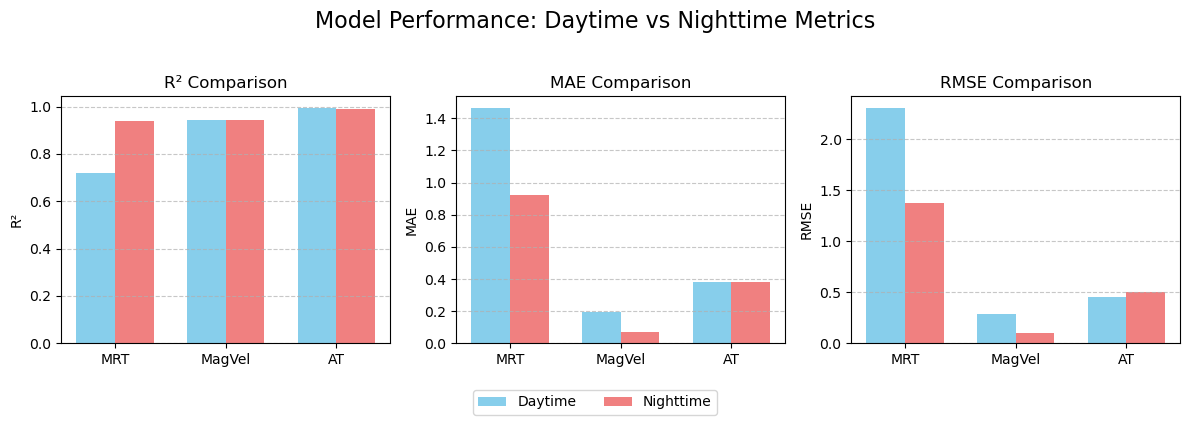

In [16]:
# ==============================
# Bar Plot of Metrics: Daytime vs Nighttime Comparison
# ==============================

metrics = ["R²", "MAE", "RMSE"]
targets = ["MRT", "MagVel", "AT"]

# --- Set up figure and axis for side-by-side metric comparison ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # A4-friendly layout
bar_handles = []  # For shared legend

# --- Plot each metric ---
for idx, metric in enumerate(metrics):
    day_vals = [metrics_summary[t]["day"][metric] for t in targets]
    night_vals = [metrics_summary[t]["night"][metric] for t in targets]

    x = np.arange(len(targets))
    width = 0.35  # Width of the bars

    bars_day = axs[idx].bar(x - width/2, day_vals, width, label="Daytime", color="skyblue")
    bars_night = axs[idx].bar(x + width/2, night_vals, width, label="Nighttime", color="lightcoral")

    # Store bar handles for shared legend (only once)
    if idx == 0:
        bar_handles = [bars_day[0], bars_night[0]]

    axs[idx].set_ylabel(metric)
    axs[idx].set_title(f"{metric} Comparison")
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(targets)
    axs[idx].grid(True, axis='y', linestyle='--', alpha=0.7)

# --- Add shared legend below all plots ---
fig.legend(bar_handles, ["Daytime", "Nighttime"], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# --- Layout adjustments ---
plt.suptitle("Model Performance: Daytime vs Nighttime Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Save Model Parameters 

In [17]:
# ==============================
# Save Final Trained Models and PCA Models
# ==============================

# --- Select appropriate PCA models based on training configuration ---
PCA_models_to_save = PCA_models_bal if use_balanced else PCA_models_unbal

# --- Save each trained model and its corresponding PCA model ---
for target in ["MRT", "MagVel", "AT"]:
    joblib.dump(final_models[target], f"{target}_final_model.pkl", compress=3)   # Compress trained model
    joblib.dump(PCA_models_to_save[target], f"{target}_pca.pkl", compress=9)     # Higher compression for PCA

# --- Save min-max values of input features for future scaling/reference ---
np.save("X_features_minmax.npy", [X_features.min(axis=0), X_features.max(axis=0)])

# Plot results

Selected sample indices: [37 26 42  9  4]

Sample 1
  Hour:               24
  Windspeed [m/s]:    1.69
  Wind Dir [deg]:     84
  Solar Irrad [W/m²]: 0
  Air Temp [K]:       290.05


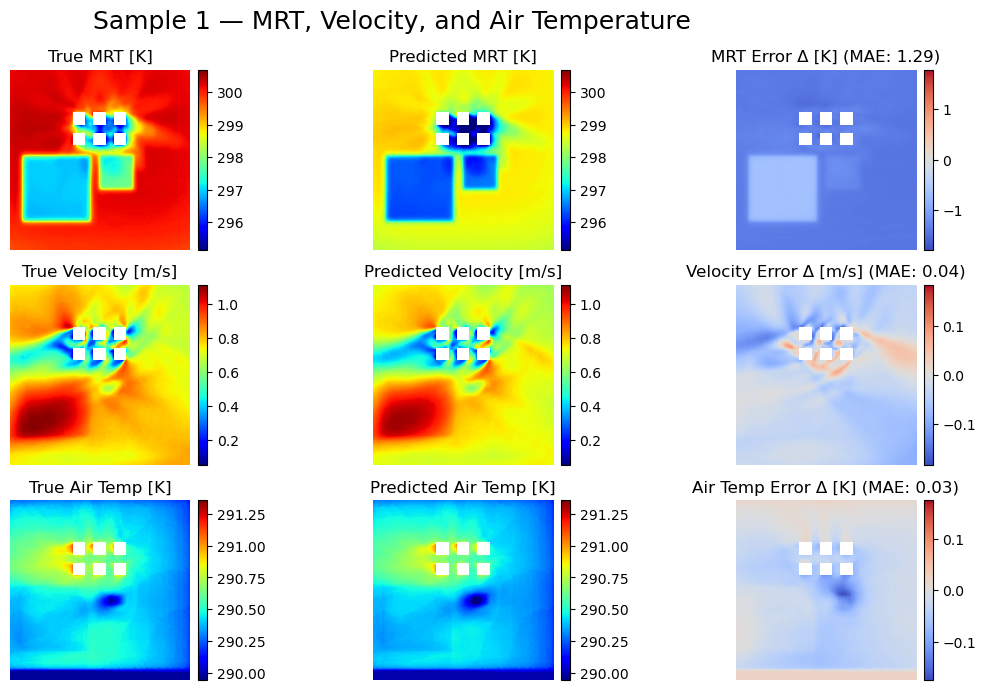


Sample 2
  Hour:               21
  Windspeed [m/s]:    2.39
  Wind Dir [deg]:     88
  Solar Irrad [W/m²]: 3
  Air Temp [K]:       290.35


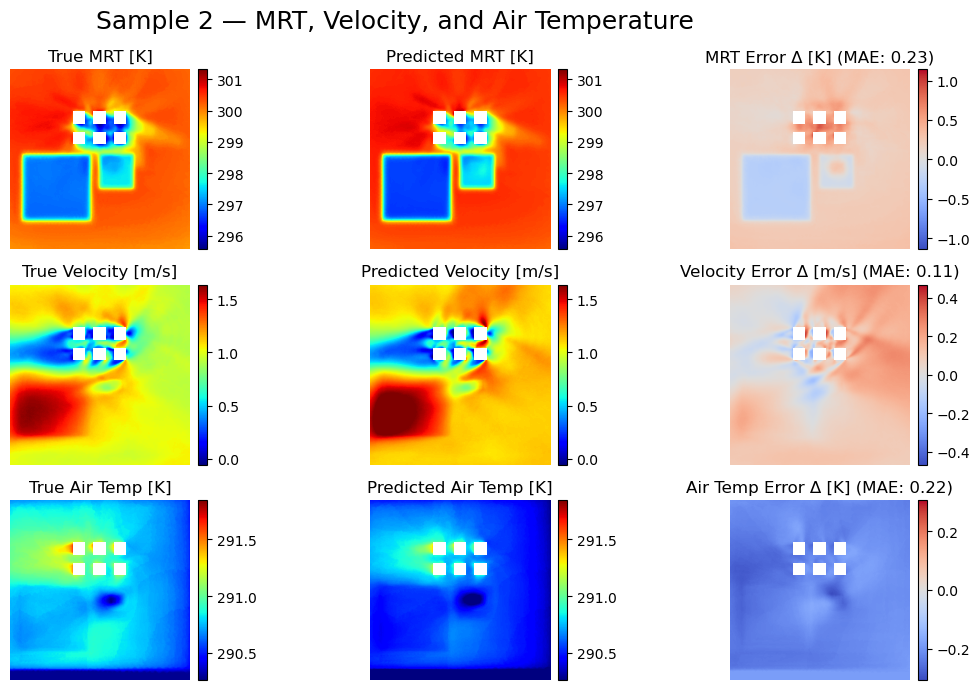


Sample 3
  Hour:               12
  Windspeed [m/s]:    2.69
  Wind Dir [deg]:     211
  Solar Irrad [W/m²]: 811
  Air Temp [K]:       296.85


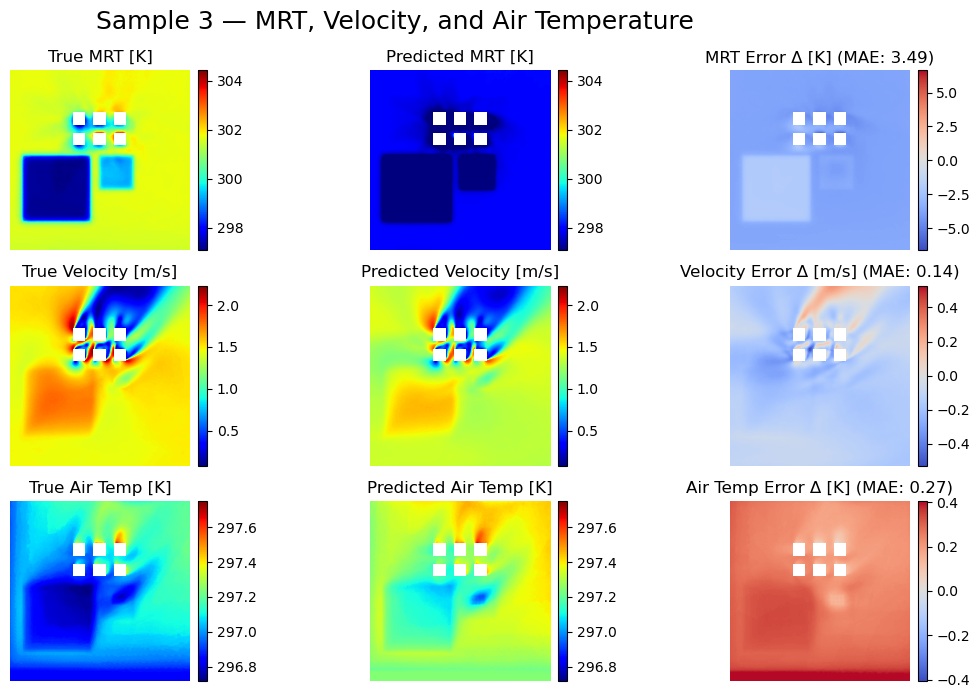


Sample 4
  Hour:               4
  Windspeed [m/s]:    1.30
  Wind Dir [deg]:     326
  Solar Irrad [W/m²]: 0
  Air Temp [K]:       293.05


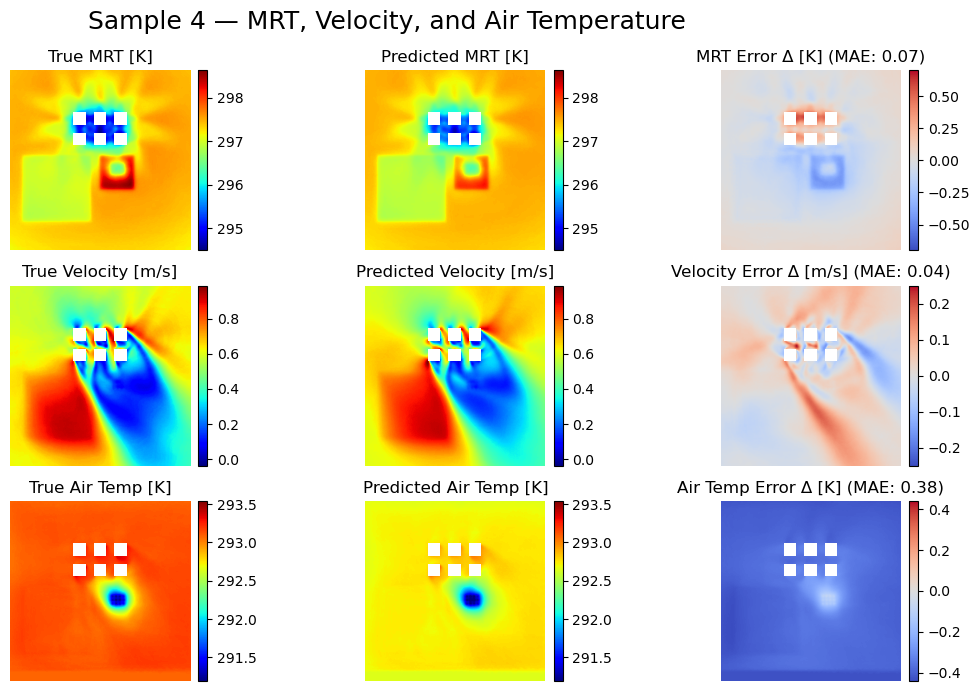


Sample 5
  Hour:               14
  Windspeed [m/s]:    5.69
  Wind Dir [deg]:     83
  Solar Irrad [W/m²]: 841
  Air Temp [K]:       298.65


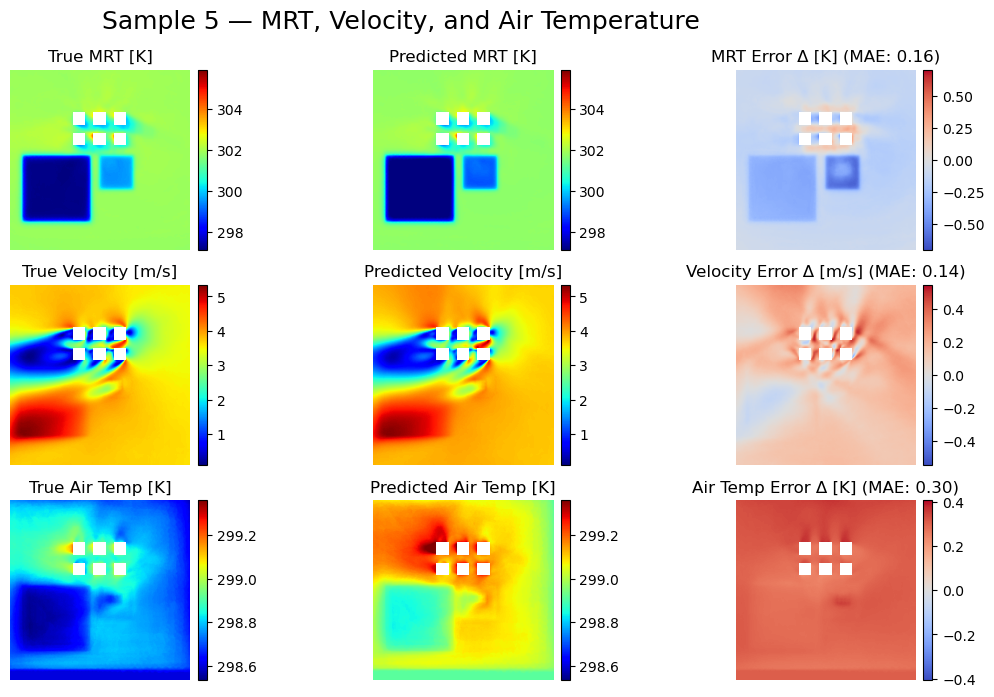

In [18]:
# ==============================
# Visualize Random Test Samples with Predictions
# ==============================

# --- Select PCA model based on training configuration ---
pca_models_test = PCA_models_bal if use_balanced else PCA_models_unbal

# --- Randomly select test indices ---
n_samples = 5
rand_indices = np.random.choice(len(X_test), size=n_samples, replace=False)
print(f"Selected sample indices: {rand_indices}")

for idx, i in enumerate(rand_indices):
    input_features = X_test[i]

    # --- Function to reconstruct and compute error image for a given target ---
    def reconstruct_and_mask(target):
        true_pca = Y_pca_data_test_current[target][i]
        pred_pca = final_models[target].predict(input_features.reshape(1, -1))[0]

        pca_model_test = pca_models_test[target]
        true_img = pca_model_test.inverse_transform(true_pca).reshape(1000, 1000)
        pred_img = pca_model_test.inverse_transform(pred_pca).reshape(1000, 1000)
        error_img = pred_img - true_img

        # Mask out non-relevant pixels
        nan_mask = (true_img == 0)
        true_img[nan_mask] = np.nan
        pred_img[nan_mask] = np.nan
        error_img[nan_mask] = np.nan

        return true_img, pred_img, error_img

    # --- Reconstruct images for each target ---
    true_mrt, pred_mrt, err_mrt = reconstruct_and_mask("MRT")
    true_vel, pred_vel, err_vel = reconstruct_and_mask("MagVel")
    true_at, pred_at, err_at = reconstruct_and_mask("AT")

    # --- Display input features ---
    print(f"\nSample {idx + 1}")
    print(f"  Hour:               {input_features[0]:.0f}")
    print(f"  Windspeed [m/s]:    {input_features[1]:.2f}")
    print(f"  Wind Dir [deg]:     {input_features[2]:.0f}")
    print(f"  Solar Irrad [W/m²]: {input_features[3]:.0f}")
    print(f"  Air Temp [K]:       {input_features[4]:.2f}")

    # --- Create 3x3 plot grid for True / Predicted / Error images ---
    fig, axs = plt.subplots(3, 3, figsize=(12, 7))

    # --- MRT Row ---
    vmin, vmax = np.nanmin(true_mrt), np.nanmax(true_mrt)
    axs[0, 0].imshow(true_mrt, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0, 0].set_title("True MRT [K]")
    plt.colorbar(axs[0, 0].images[0], ax=axs[0, 0], fraction=0.025, pad=0.02)

    axs[0, 1].imshow(pred_mrt, cmap="jet", vmin=vmin, vmax=vmax)
    axs[0, 1].set_title("Predicted MRT [K]")
    plt.colorbar(axs[0, 1].images[0], ax=axs[0, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_mrt))
    mae_mrt = np.nanmean(np.abs(err_mrt))
    axs[0, 2].imshow(err_mrt, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[0, 2].set_title(f"MRT Error Δ [K] (MAE: {mae_mrt:.2f})")
    plt.colorbar(axs[0, 2].images[0], ax=axs[0, 2], fraction=0.025, pad=0.02)

    # --- Velocity Row ---
    vmin, vmax = np.nanmin(true_vel), np.nanmax(true_vel)
    axs[1, 0].imshow(true_vel, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1, 0].set_title("True Velocity [m/s]")
    plt.colorbar(axs[1, 0].images[0], ax=axs[1, 0], fraction=0.025, pad=0.02)

    axs[1, 1].imshow(pred_vel, cmap="jet", vmin=vmin, vmax=vmax)
    axs[1, 1].set_title("Predicted Velocity [m/s]")
    plt.colorbar(axs[1, 1].images[0], ax=axs[1, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_vel))
    mae_vel = np.nanmean(np.abs(err_vel))
    axs[1, 2].imshow(err_vel, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[1, 2].set_title(f"Velocity Error Δ [m/s] (MAE: {mae_vel:.2f})")
    plt.colorbar(axs[1, 2].images[0], ax=axs[1, 2], fraction=0.025, pad=0.02)

    # --- Air Temperature Row ---
    vmin, vmax = np.nanmin(true_at), np.nanmax(true_at)
    axs[2, 0].imshow(true_at, cmap="jet", vmin=vmin, vmax=vmax)
    axs[2, 0].set_title("True Air Temp [K]")
    plt.colorbar(axs[2, 0].images[0], ax=axs[2, 0], fraction=0.025, pad=0.02)

    axs[2, 1].imshow(pred_at, cmap="jet", vmin=vmin, vmax=vmax)
    axs[2, 1].set_title("Predicted Air Temp [K]")
    plt.colorbar(axs[2, 1].images[0], ax=axs[2, 1], fraction=0.025, pad=0.02)

    vmax_err = np.nanmax(np.abs(err_at))
    mae_at = np.nanmean(np.abs(err_at))
    axs[2, 2].imshow(err_at, cmap="coolwarm", vmin=-vmax_err, vmax=vmax_err)
    axs[2, 2].set_title(f"Air Temp Error Δ [K] (MAE: {mae_at:.2f})")
    plt.colorbar(axs[2, 2].images[0], ax=axs[2, 2], fraction=0.025, pad=0.02)

    # --- Clean up axes ---
    for ax in axs.ravel():
        ax.axis("off")

    plt.suptitle(f"Sample {idx + 1} — MRT, Velocity, and Air Temperature", fontsize=18)
    plt.tight_layout()
    plt.show()

# Visualize Error per Input Variable

In [19]:
# ==============================
# Track Mean Absolute Error (MAE) Per Sample for All Targets
# ==============================

# --- Storage for MAE values and corresponding input features ---
mae_all = {"MRT": [], "MagVel": [], "AT": []}
input_features_all = {"MRT": [], "MagVel": [], "AT": []}

# --- Use PCA models based on the current training configuration ---
pca_models_test = PCA_models_bal if use_balanced else PCA_models_unbal

# --- Loop through each target variable ---
for target in ["MRT", "MagVel", "AT"]:
    pca_model = pca_models_test[target]
    model = final_models[target]

    # --- Evaluate MAE for each test sample ---
    for i in range(len(X_test)):
        true_pca = Y_pca_data_test_current[target][i]
        pred_pca = model.predict(X_test[i].reshape(1, -1))[0]

        true_img = pca_model.inverse_transform(true_pca).reshape(1000, 1000)
        pred_img = pca_model.inverse_transform(pred_pca).reshape(1000, 1000)
        error_img = pred_img - true_img

        # Mask out invalid pixels
        nan_mask = (true_img == 0)
        error_img[nan_mask] = np.nan

        # Compute Mean Absolute Error for the sample
        mae = np.nanmean(np.abs(error_img))

        # Store MAE and input features for analysis
        mae_all[target].append(mae)
        input_features_all[target].append(X_test[i])

    # Convert lists to numpy arrays for further analysis
    mae_all[target] = np.array(mae_all[target])
    input_features_all[target] = np.array(input_features_all[target])

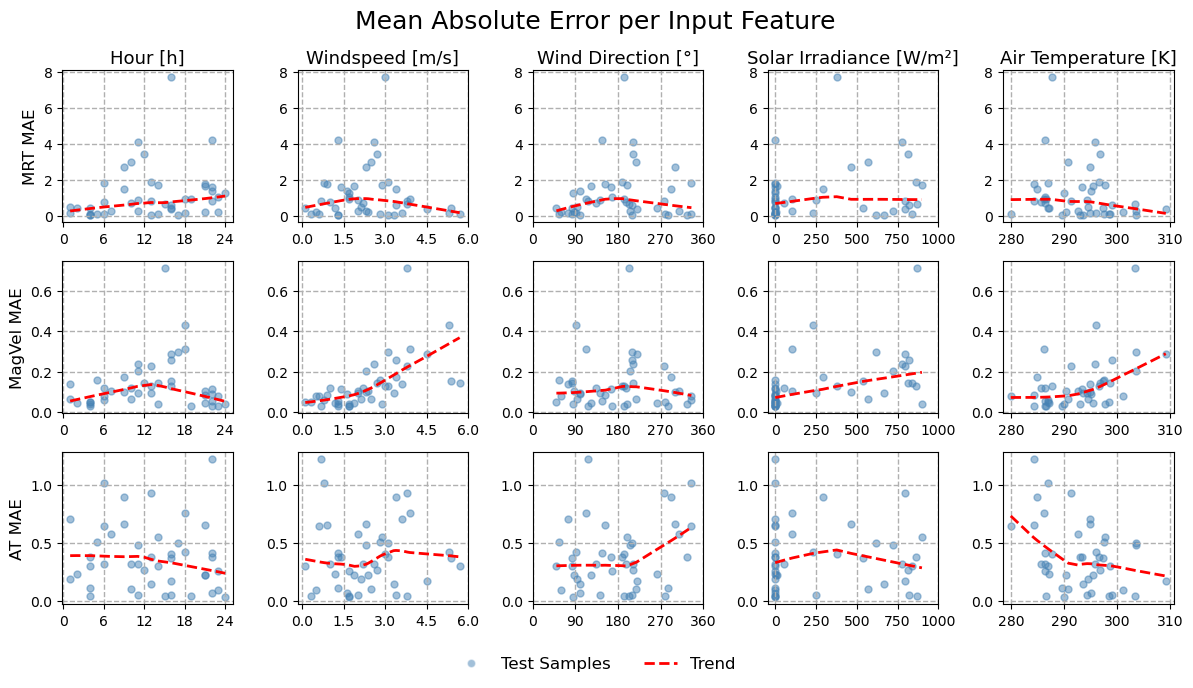

In [ ]:
# ==============================
# Final Tight Layout for Paper Submission
# ==============================

feature_labels = ["Hour [h]", "Windspeed [m/s]", "Wind Direction [°]", "Solar Irradiance [W/m²]", "Air Temperature [K]"]
targets = ["MRT", "MagVel", "AT"]
xticks_dict = {
    "Hour [h]": [0, 6, 12, 18, 24],
    "Windspeed [m/s]": [0, 1.5, 3, 4.5, 6],
    "Wind Direction [°]": [0, 90, 180, 270, 360],
    "Solar Irradiance [W/m²]": [0, 250, 500, 750, 1000],
    "Air Temperature [K]": [280, 290, 300, 310]
}
fig, axs = plt.subplots(len(targets), 5, figsize=(12, 2.4 * len(targets)))  

scatter_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=6, alpha=0.5)
lowess_proxy = plt.Line2D([0], [0], linestyle='--', color='red', linewidth=2)

for t_idx, target in enumerate(targets):
    for f_idx in range(5):
        ax = axs[t_idx, f_idx]
        x = input_features_all[target][:, f_idx]
        y = mae_all[target]
        # Scatter plot
        ax.scatter(x, y, alpha=0.5, color='steelblue', s=25)
        # LOWESS smoothing
        lowess_frac = 0.8
        smoothed = lowess(y, x, frac=lowess_frac, return_sorted=True)
        ax.plot(smoothed[:, 0], smoothed[:, 1], color='red', linestyle='--', linewidth=2)
        xlabel = feature_labels[f_idx]
        xticks = xticks_dict[xlabel]
        ax.set_xticks(xticks)
        ax.grid(True, which='both', linestyle='--', linewidth=0.6)
        ax.xaxis.grid(True, which='major', linewidth=1.0)
        ax.yaxis.grid(True, which='major', linewidth=1.0)

        if f_idx == 0:
            ax.set_ylabel(f"{target} MAE", fontsize=12)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        if t_idx == 0:
            ax.set_title(xlabel, fontsize=13, pad=5) 
fig.legend([scatter_proxy, lowess_proxy], ['Test Samples', 'Trend'],
           loc='lower center', ncol=2, fontsize=12, frameon=False, bbox_to_anchor=(0.5, 0.01))
plt.subplots_adjust(
    wspace=-0.5, 
    hspace=0.25  
)
plt.suptitle("Mean Absolute Error per Input Feature", fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.07, 1, 0.97]) 
plt.show()

In [21]:
# === Print training ranges ===
X_arr = np.array(X_features)
input_names = ["Hour", "Windspeed (m/s)", "Wind Dir (deg)", "Solar Irrad (W/m²)", "Air Temp (K)"]
print("Training Data Ranges:")

for i, name in enumerate(input_names):
    min_val = np.min(X_arr[:, i])
    max_val = np.max(X_arr[:, i])
    print(f"  {name:>25}: {min_val:.2f} to {max_val:.2f}")



Training Data Ranges:
                       Hour: 1.00 to 24.00
            Windspeed (m/s): 0.11 to 6.31
             Wind Dir (deg): 3.00 to 353.00
         Solar Irrad (W/m²): 0.00 to 973.00
               Air Temp (K): 279.95 to 310.05
